Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Workflow Profiling

This notebook discusses the use of the `monai.utils.WorkflowProfiler` used to gather information about time requirements of various parts of your workflow. This will cover assessing the time spent in transforms, generating batches, training forward and backward passes, etc. This class gathers information using tracing about what functions/methods are called as well as marking explicit constructs to profile, such as callables and context blocks. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/workflow_profiling.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q monai-weekly

## Setup imports

In [1]:
import matplotlib.pyplot as plt
import monai
import monai.transforms as mt
import numpy as np
import torch
from monai.config import print_config
from monai.data import DataLoader, Dataset, create_test_image_3d
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.utils import ProfileHandler, WorkflowProfiler
from monai.utils.enums import CommonKeys

print_config()

MONAI version: 1.2.0+148.g7dfdcb94.dirty
Numpy version: 1.22.2
Pytorch version: 2.0.0a0+1767026
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7dfdcb94eb42ac0f3af80f3c8e32421facd536ea
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.4.0
pynrrd version: 1.0.0
clearml version: 1.11.1rc1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Profiling Components

The `WorkflowProfiler` defines a context manager which is used to start and stop its internal results reading thread and configure tracing. Typically all profiling should be done with the context otherwise the results may not be read and so won't appear in the summary. Methods of this class are provided to create separate context blocks used to time how long it takes to enter and exit, wrappers around callables to time how long calls take, and iterables to time how long item generation takes.

Here the test synthetic dataset is created within such a context to demonstrate using sub-blocks to time parts of a workflow and wrapping callables:

In [2]:
dataset = []
num_items = 30
im_shape = (128, 128, 128)

# create the profiler using None to disable tracing for now
with WorkflowProfiler(call_selector=None) as wp:
    # wrap create_test_image_3d in a function which will log how long invocations take
    gen_func = wp.profile_callable("Data generation func")(create_test_image_3d)

    # enclose code in this context which recalls how long execution took
    with wp.profile_ctx("Generation loop"):
        for _ in range(num_items):
            img, seg = gen_func(*im_shape, num_seg_classes=1)

            dataset.append({CommonKeys.IMAGE: img, CommonKeys.LABEL: seg})

print(wp.get_times_summary())

{'Data generation func': (30, 1.2739437690000004, 0.04246479230000001, 0.003321578522194533, 0.040405682000000005, 0.054325267000000003), 'Generation loop': (1, 1.6376470150000002, 1.6376470150000002, 0.0, 1.6376470150000002, 1.6376470150000002)}


The times summary this produced isn't terribly legible in this form so let's use Pandas to make a nice table in Jupyter:

In [3]:
wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Generation loop,1,1.637647,1.637647,0.000000,1.637647,1.637647
Data generation func,30,1.273944,0.042465,0.003322,0.040406,0.054325


This gives time summaries for the two constructs that were profiled. The "Generation loop" context was entered only once while the "Data generation func" (which was `create_test_image_3d` wrapped in another callable) was called multiple times. A context can be entered and exited multiple times, and multiple different context blocks can have the same name thus accumulating results in one place. 

The raw results can be queried with `get_results` which ensures thread and process safety. This should be called outside the enclosing context to ensure that thread finalisation has taken place before results are gathered. 

In [4]:
results = wp.get_results()
print(results)

{'Data generation func': (ProfileResult(name='Data generation func', time=47398909, filename='/usr/lib/python3.8/contextlib.py', lineno=74, pid=1480146, timestamp='2023-09-25 08:08:06.023334'), ProfileResult(name='Data generation func', time=42221740, filename='/usr/lib/python3.8/contextlib.py', lineno=74, pid=1480146, timestamp='2023-09-25 08:08:06.077886'), ProfileResult(name='Data generation func', time=41500623, filename='/usr/lib/python3.8/contextlib.py', lineno=74, pid=1480146, timestamp='2023-09-25 08:08:06.131292'), ProfileResult(name='Data generation func', time=41121253, filename='/usr/lib/python3.8/contextlib.py', lineno=74, pid=1480146, timestamp='2023-09-25 08:08:06.184417'), ProfileResult(name='Data generation func', time=42069167, filename='/usr/lib/python3.8/contextlib.py', lineno=74, pid=1480146, timestamp='2023-09-25 08:08:06.238471'), ProfileResult(name='Data generation func', time=41670790, filename='/usr/lib/python3.8/contextlib.py', lineno=74, pid=1480146, timesta

The result is a dictionary relating construct names to a list of invocations. Each call or execution of a construct produces a `ProfileResult` object to store information about the call, specifically `time` records how many nanoseconds were taken. Stack inspection and tracing is used to, as best as possible, record where the invocation was in code. The PID is also recorded since results can be collected from subprocesses when `DataLoader` objects are used with process workers. 

## Transform Profiling

Profiling how long each transform takes when executing a pipeline is complex owing to difficulting in determining when a transform runs, what times are taken, what transforms call others, etc. The `WorkflowProfiler` class uses tracing to profile all function/method calls matching a given criteria. In the previous example the criteria function was `None` to disable tracing, however the default is a function which selects only the `__call__` methods of `Transforms` instances. This includes top-level transforms and those called by others, but gives a useful idea of time taken relative to one another. Note that tracing is expensive so the times given are not real-world times but are still useful to identify which transform is expensive. 

torch.Size([1, 128, 128, 128]) torch.float32
torch.Size([1, 128, 128, 128]) torch.float32


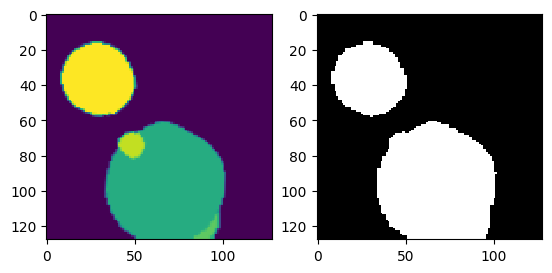

In [5]:
both_keys = (CommonKeys.IMAGE, CommonKeys.LABEL)
rand_prob = 0.5

trans = [
    mt.EnsureChannelFirstd(both_keys, channel_dim="no_channel"),
    mt.RandSpatialCropd(both_keys, (96, 96, 96), random_size=False),
    mt.ScaleIntensityd(CommonKeys.IMAGE),
    mt.RandAxisFlipd(both_keys, rand_prob),
    mt.RandRotate90d(both_keys, prob=rand_prob, spatial_axes=[0, 1]),
    mt.RandSmoothDeformd(
        keys=both_keys,
        spatial_size=im_shape,
        rand_size=(3, 3, 3),
        pad=2,
        def_range=0.1,
        field_mode=monai.utils.InterpolateMode.TRILINEAR,
        grid_mode=(monai.utils.GridSampleMode.BILINEAR, monai.utils.GridSampleMode.NEAREST),
        align_corners=True,
        prob=1.0,
    ),
    mt.EnsureTyped(both_keys, dtype=(np.float32, np.int32)),
]

train_trans = mt.Compose(trans)

with WorkflowProfiler() as wp:
    test = train_trans(dataset[0])

print(test[CommonKeys.IMAGE].shape, test[CommonKeys.IMAGE].dtype)
print(test[CommonKeys.LABEL].shape, test[CommonKeys.LABEL].dtype)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(test[CommonKeys.IMAGE][0, 48], interpolation="none")
ax1.imshow(test[CommonKeys.LABEL][0, 48], interpolation="none", cmap="gray")

The results is now populated with calls to the `__call__` methods of every transform mentioned above and all those they use. Although tracing has high overhead this still demonstrates that `RandSmoothDeformd` (which uses `RandSmoothDeform`) is the slowest transform defined above by a large margin. Many transforms have very fast total time if by chance they were skipped since their `prob` arguments are less than 1.0. For multiple runs of the same sequence, ie. when generating a whole batch, the results will be more indicative of the time proportion each transform uses. 

In [6]:
wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Compose.__call__,1,0.117255,0.117255,0.000000,0.117255,0.117255
RandSmoothDeformd.__call__,1,0.104854,0.104854,0.000000,0.104854,0.104854
RandSmoothDeform.__call__,2,0.104426,0.052213,0.014874,0.037340,0.067087
RandSpatialCrop.__call__,4,0.006386,0.001597,0.000366,0.001166,0.002016
RandSpatialCropd.__call__,1,0.003592,0.003592,0.000000,0.003592,0.003592
RandRotate90d.__call__,1,0.003427,0.003427,0.000000,0.003427,0.003427
Rotate90.__call__,2,0.002973,0.001486,0.000061,0.001425,0.001547
ScaleIntensityd.__call__,1,0.001870,0.001870,0.000000,0.001870,0.001870
ScaleIntensity.__call__,1,0.001776,0.001776,0.000000,0.001776,0.001776
EnsureChannelFirstd.__call__,1,0.001445,0.001445,0.000000,0.001445,0.001445


The call selection function can be substituted with any callable which accepts a `frame` object used by `sys.settrace` and `threading.settrace` and returns `True` if the call the frame represents should be traced. The default inspects the frame and returns true if the call is `__call__` and the receiver is a `Transform` instance:

```python
def select_transform_call(frame):
    """Returns True if `frame` is a call to a `Transform` object's `_call__` method."""
    from monai.transforms import Transform  # prevents circular import

    self_obj = frame.f_locals.get("self", None)
    return frame.f_code.co_name == "__call__" and isinstance(self_obj, Transform)
```

You can provide your own criteria functions to replace this one, just don't provide one which traces all calls since this will lead to infinite recursion and be incredibly slow even if that was avoided.

An alternative function to trace only nominated objects may be more useful to narrow the scope of the trace to top-level transforms only: 

In [7]:
class TraceObjectsOnly:
    def __init__(self, objects):
        self.objects = objects

    def __call__(self, frame):
        self_obj = frame.f_locals.get("self", None)
        return frame.f_code.co_name == "__call__" and self_obj in self.objects


# `trans` is the list of transforms defined above, not the Compose object
with WorkflowProfiler(TraceObjectsOnly(trans)) as wp:
    test = train_trans(dataset[0])

wp.get_times_summary_pd()  # much more concise view of what's going on

,Count,Total Time (s),Avg,Std,Min,Max
RandSmoothDeformd.__call__,1,0.092891,0.092891,0.0,0.092891,0.092891
RandSpatialCropd.__call__,1,0.006538,0.006538,0.0,0.006538,0.006538
ScaleIntensityd.__call__,1,0.004565,0.004565,0.0,0.004565,0.004565
RandAxisFlipd.__call__,1,0.002347,0.002347,0.0,0.002347,0.002347
RandRotate90d.__call__,1,0.001494,0.001494,0.0,0.001494,0.001494
EnsureChannelFirstd.__call__,1,0.000542,0.000542,0.0,0.000542,0.000542
EnsureTyped.__call__,1,0.000367,0.000367,0.0,0.000367,0.000367


## Whole Workflow Profiling

These elements can now be combined to profile all the aspects of the typically Pytorch training workflow:

In [8]:
device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_func = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)
num_epochs = 3
batch_size = 5


with WorkflowProfiler(TraceObjectsOnly(trans)) as wp:
    # profile how long it takes to create the dataset and loader, this could be long for different dataset types
    with wp.profile_ctx("Create DataLoader"):
        ds = Dataset(dataset, train_trans)
        dl = DataLoader(ds, batch_size=batch_size, num_workers=4)

    # break passes into functions which can be decorated, context blocks in the training loop could be used instead

    @wp.profile_callable()
    def forward_pass(batch):
        img = batch[CommonKeys.IMAGE].to(device)
        seg = batch[CommonKeys.LABEL].to(device)

        return net(img), seg

    @wp.profile_callable()
    def backward_pass(pred, seg):
        loss = loss_func(pred, seg)
        loss.backward()
        return loss

    for epoch in range(1, 1 + num_epochs):
        print("Epoch", epoch)

        # allows measuring how long each epoch takes
        with wp.profile_ctx("Epoch"):
            # measures how long batch generation takes
            for batch in wp.profile_iter("Batch generation", dl):
                opt.zero_grad()
                pred, seg = forward_pass(batch)
                loss = backward_pass(pred, seg)
                opt.step()
                print(loss.item())

wp.get_times_summary_pd()

Epoch 1
0.632347047328949
0.6424596905708313
0.5509625673294067
0.4700535833835602
0.5107573866844177
0.512077271938324
Epoch 2
0.4802013337612152
0.5469694137573242
0.4922555088996887
0.4222610890865326
0.4443279206752777
0.45488134026527405
Epoch 3
0.4441751539707184
0.5135425925254822
0.46540212631225586
0.3792388141155243
0.4192323386669159
0.4318554103374481


,Count,Total Time (s),Avg,Std,Min,Max
RandSmoothDeformd.__call__,90,21.831027,0.242567,0.020258,0.203764,0.304642
Epoch,3,8.985920,2.995307,0.087524,2.927028,3.118856
Batch generation,18,5.026321,0.279240,0.463398,0.000062,1.337905
forward_pass,18,0.454474,0.025249,0.031146,0.015030,0.153217
ScaleIntensityd.__call__,90,0.380329,0.004226,0.001956,0.002278,0.010741
backward_pass,18,0.219559,0.012198,0.037680,0.002481,0.167538
RandRotate90d.__call__,90,0.145601,0.001618,0.002447,0.000260,0.020887
EnsureTyped.__call__,90,0.136556,0.001517,0.000452,0.000841,0.002603
RandAxisFlipd.__call__,90,0.124048,0.001378,0.001194,0.000299,0.005235
RandSpatialCropd.__call__,90,0.121727,0.001353,0.000433,0.001055,0.003184


Workflows using Ignite Engine classes can be profiled as well to get very similar results by using `ProfileHandler` to track certain pairs of events. In this example batch generation, iteration, and epoch time are measured using this handler in place of iterator and callable profiling:

In [9]:
from monai.engines import SupervisedTrainer  # noqa
from ignite.engine import Events  # noqa

device = torch.device("cuda:0")
net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_func = DiceLoss(sigmoid=True)
lr = 1e-3
opt = torch.optim.Adam(net.parameters(), lr)
num_epochs = 3
batch_size = 5

with WorkflowProfiler() as wp:
    with wp.profile_ctx("Create DataLoader"):
        ds = Dataset(dataset, train_trans)
        dl = DataLoader(ds, batch_size=batch_size, num_workers=4)

    trainer = SupervisedTrainer(
        device=device,
        max_epochs=num_epochs,
        train_data_loader=dl,
        network=net,
        optimizer=opt,
        loss_function=loss_func,
    )

    epoch_h = ProfileHandler("Epoch", wp, Events.EPOCH_STARTED, Events.EPOCH_COMPLETED).attach(trainer)
    iter_h = ProfileHandler("Iteration", wp, Events.ITERATION_STARTED, Events.ITERATION_COMPLETED).attach(trainer)
    batch_h = ProfileHandler("Batch gen", wp, Events.GET_BATCH_STARTED, Events.GET_BATCH_COMPLETED).attach(trainer)

    trainer.run()

wp.get_times_summary_pd()

,Count,Total Time (s),Avg,Std,Min,Max
Compose.__call__,90,22.663719,0.251819,0.027767,0.209441,0.304443
RandSmoothDeformd.__call__,90,21.457371,0.238415,0.025981,0.200652,0.283412
RandSmoothDeform.__call__,180,21.422791,0.119016,0.017444,0.088241,0.152806
Epoch,3,8.840104,2.946701,0.024437,2.914117,2.972967
Batch gen,18,5.106108,0.283673,0.499145,0.000148,1.463968
Iteration,18,2.140077,0.118893,0.007366,0.111051,0.135437
Decollated.__call__,36,1.553105,0.043142,0.042523,0.000553,0.088441
ScaleIntensityd.__call__,90,0.382803,0.004253,0.001630,0.002289,0.009115
ScaleIntensity.__call__,90,0.371928,0.004133,0.001590,0.002229,0.008981
RandSpatialCrop.__call__,360,0.326454,0.000907,0.001054,0.000493,0.007946
